In [1]:
"""
Created By    : Lynnlee Rosolino
Creation Date : 23 November 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #03 - Statistical Objective Analysis

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using statistical objective analysis.
First we used a Barnes weighting analysis to compute a background field.
We then used a forward interpolation to get values at observation locations.
We then completed three statistical objective analyses using the 2, 4, and 10 
closest observations. We finally calculated analysis increments, analysis 
differences, and RMS values for each SOA.

"""
__author__    = "Lynnlee Rosolino"
__contact__   = "lynnlee.rosolino@und.edu"

In [2]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles
!pip install pandas
import pandas as pd                #pandas to spite jared

In [3]:
### Read in observations ###
data=pd.read_csv("RAOBs_201903131200.txt", delimiter=",",names=["station","lat","lon","500mbheight","500mbwinddir","500mbwindspeed"])
data[data.columns[1:5]]=data[data.columns[1:5]].astype(float) #numbers
#convert lat&lon to radians and add to data
data["lat_rad"]=data['lat']*(np.pi/180)
data["lon_rad"]=data['lon']*(np.pi/180)

#constants
mapproj=1/(15e6)
rho=6371*1e5
lambda0=-115
phi0=60*(np.pi/180)
f0=data["500mbheight"].values #heights in roi
f0=np.array(f0)

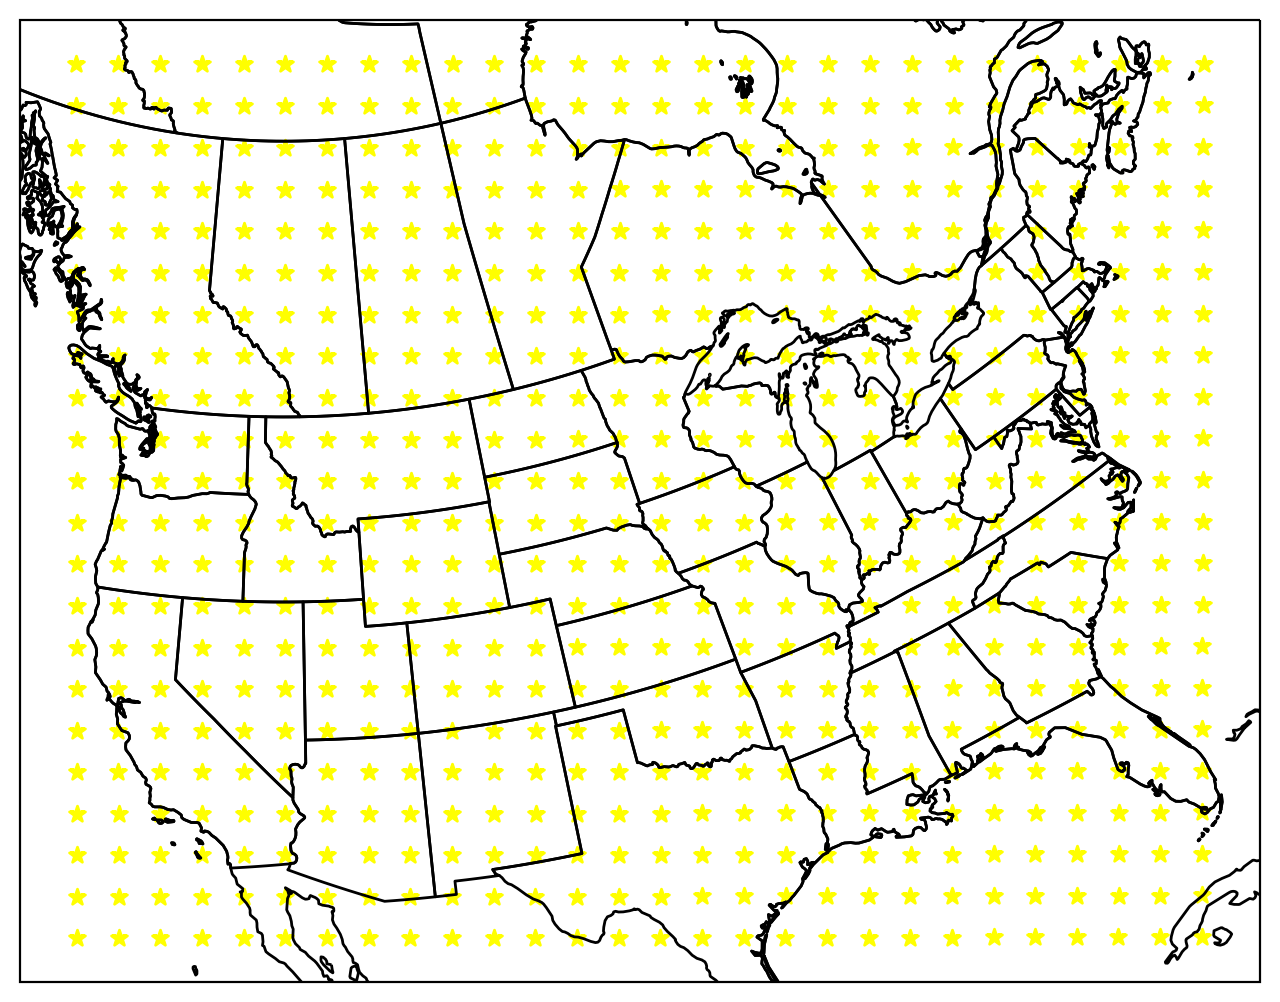

In [4]:
### Set up analysis map with a 22x28 rectangular grid of points ###
#find grid points, set up x-y grid
x_step=18.9+np.arange(22)*1.27
y_step=-6.3+np.arange(28)*1.27
x,y =np.meshgrid(x_step,y_step)

#transform equations into lat/lon
xlon=np.arctan(y/x)*(180/np.pi)+lambda0
ylat=(180/np.pi)*((np.pi/2)-(2*np.arctan(np.sqrt((x/mapproj)**2+(y/mapproj)**2)/(rho*(1+np.sin(phi0))))))

#plot to confirm i'm not stupid
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

ax1.scatter(xlon,ylat,transform=ccrs.PlateCarree(),marker="*",color="yellow")

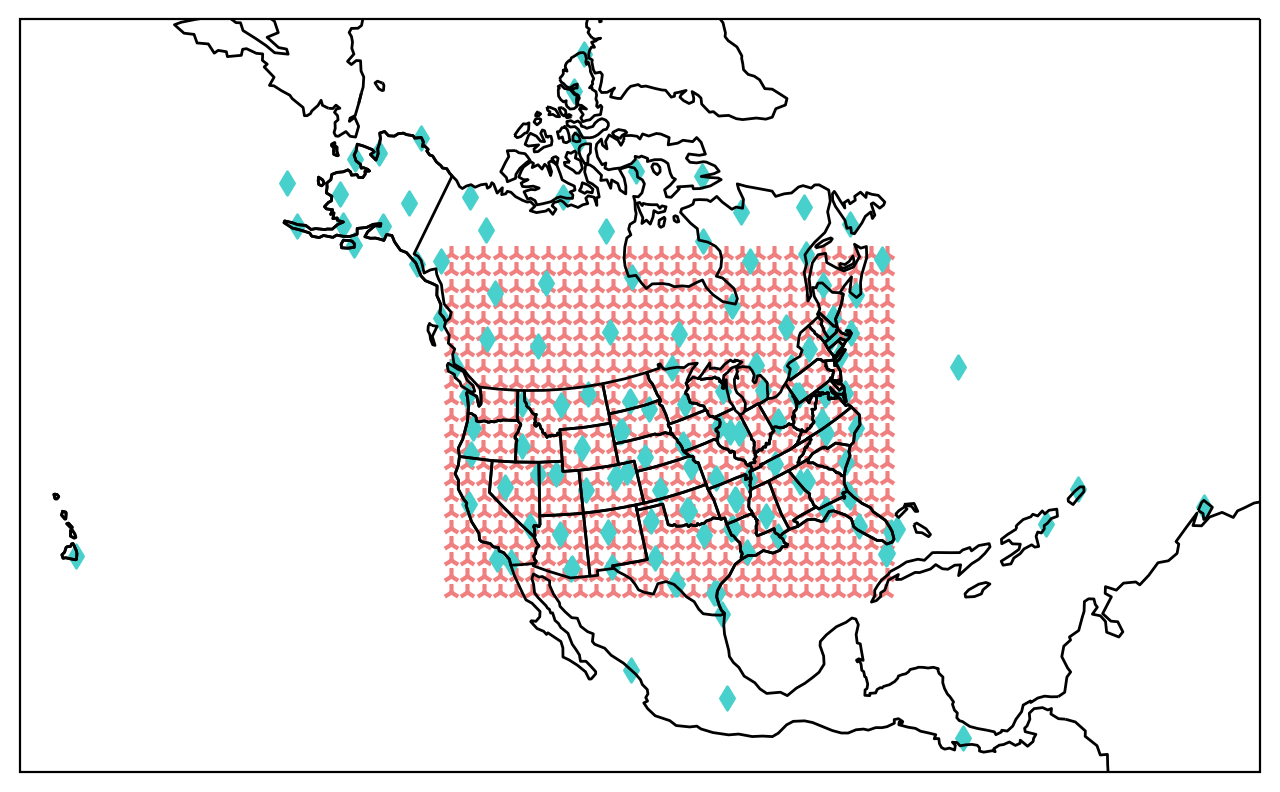

In [5]:
### convert obs lat/long to x,y ###
#assign vars
phi=data["lat_rad"]
lambdy=data["lon_rad"]

#solve for image scale factor
sigma=(1+np.sin(phi0))/(1+np.sin(phi))

#solve radius of lat circle
r=rho*sigma*np.cos(phi)

#deviation of lon from standard
dev=lambdy-(lambda0*np.pi/180)
xdev=r*np.cos(dev)*mapproj
ydev=r*np.sin(dev)*mapproj

#convert to array
xdev=np.array(xdev)
ydev=np.array(ydev)

#convert back to lat/lon
data_lon=np.arctan(ydev/xdev)*(180/np.pi)+lambda0
data_lat=(180/np.pi)*((np.pi/2)-(2*np.arctan(np.sqrt((xdev/mapproj)**2+(ydev/mapproj)**2)/(rho*(1+np.sin(phi0))))))

#plot to confirm i'm not stupid
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
ax1.scatter(xlon,ylat,transform=ccrs.PlateCarree(),marker="2",color="lightcoral")
ax1.scatter(data_lon,data_lat,transform=ccrs.PlateCarree(),marker="d",color="mediumturquoise")

In [6]:
### Create function for Barnes Analysis ###
def barnes(dik,R):
    if(dik<=R):
        Kd=10.8844524           #unit is cm^2
        w=np.exp((-dik**2)/Kd)
    elif(dik>R):
        w=0
    else:
        print("WRONG!")
    return w

In [7]:
### Create function for bilinear interpolation ###
#this one is for obs points
def bilinear(x,y):
    rel_x=x-np.floor(x)
    rel_y=y-np.floor(y)
    
    z1=bgmat[int(np.floor(y)),int(np.floor(x))]
    z2=bgmat[int(np.ceil(y)),int(np.floor(x))]
    z3=bgmat[int(np.ceil(y)),int(np.ceil(x))]
    z4=bgmat[int(np.floor(y)),int(np.ceil(x))]
    
    #delta x and delta y are both one so I'm going to ignore the first term
    P=((rel_x-1)*(rel_y-1)*z1)-((rel_x-0)*(rel_y-1)*z2)+((rel_x-0)*(rel_y-0)*z3)-((rel_x-1)*(rel_y-0)*z4)
    return P

In [8]:
### Create function for bilinear interpolation ###
#this one is for analysis points
def bilinear2(x,y,N):
    rel_x=x-np.floor(x)
    rel_y=y-np.floor(y)
    
    z1=analmat[int(np.floor(y)),int(np.floor(x)),N]
    z2=analmat[int(np.ceil(y)),int(np.floor(x)),N]
    z3=analmat[int(np.ceil(y)),int(np.ceil(x)),N]
    z4=analmat[int(np.floor(y)),int(np.ceil(x)),N]
    
    #delta x and delta y are both one so I'm going to ignore the first term
    P=((rel_x-1)*(rel_y-1)*z1)-((rel_x-0)*(rel_y-1)*z2)+((rel_x-0)*(rel_y-0)*z3)-((rel_x-1)*(rel_y-0)*z4)
    return P

In [9]:
### Create function for schlatter ###
#convert 1.24 to distance on earth
#see I did do it in Python!!
sig=(1+np.sin(np.pi/3))/(1+np.sin((40*np.pi)/180))
mm=1.24/sig
def schlatter(dik):
    rho_dik=0.95*np.exp(-mm*(dik**2))
    rho_dik[dik<1e-3]=1
    return rho_dik

In [10]:
#first pass background
yrow=22
xcol=28
re = 12.7775892
r=np.array([re])    #unit is cm
bgmat=np.zeros((xcol,yrow))

#feelin loopy after writin this loop
for j in range(len(x)):
    for k in range(len(x[0])):
        xs=x[j,k]-xdev   #grid point - loc of obs
        ys=y[j,k]-ydev   #grid point - loc of obs
        radius=((xs**2)+(ys**2))**(1/2)  #distance formula
        #make sure obs are in roi
        roi_index=np.where(radius<=r)[0]
        #empty matrix for weights
        weights=np.zeros(len(xdev))
        for i in roi_index:
            w=barnes(radius[i],r)
            weights[i]=w
        bgmat[j,k]=np.sum(weights*f0)/np.sum(weights)       
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(xlon,ylat,bgmat[:,:],colors='mediumpurple',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("background")
#plt.savefig('background.png')
plt.close()

In [11]:
#forward interpolation-get values at ob locations
#calculate relative x and y for bilinear
ob_relx=(xdev-18.9)/1.27
ob_rely=(ydev+6.3)/1.27
P1=np.zeros(len(xdev))

#bilinear to find analysis values at ob locations
for i in range(len(ob_relx)):
    #if ob in grid use bilinear
    if(ob_relx[i]>=0) and (ob_relx[i]<21) and (ob_rely[i]>=0) and (ob_rely[i]<27):
        p=bilinear(ob_relx[i],ob_rely[i]) #zero uses analysis value from first pass
    else:
        xs=xdev[i]-x   #flip grid point - loc of obs
        ys=ydev[i]-y   #flip grid point - loc of obs
        radius=((xs**2)+(ys**2))**(1/2)  #distance formula
        impt_vals_a=np.where(radius<=r)
        weights_a=np.zeros(x.shape)
        for j in impt_vals_a[0]:
            for k in impt_vals_a[1]:
                barnes_a=barnes(radius[j,k],r)
                weights_a[j,k]=barnes_a
        p=np.sum(weights_a*bgmat[:,:])/np.sum(weights_a)
    P1[i]=p

C:\Users\lynnl\AppData\Local\Temp\ipykernel_50328\1686581571.py:22: RuntimeWarning: invalid value encountered in double_scalars
  p=np.sum(weights_a*bgmat[:,:])/np.sum(weights_a)


In [12]:

N=[2,4,10]
analmat=np.zeros((xcol,yrow,len(N)))
for n in range(len(N)):
    numpoints=N[n]
    for j in range(len(x)):
        for k in range(len(x[0])):
            xs=x[j,k]-xdev   #grid point - loc of obs
            ys=y[j,k]-ydev   #grid point - loc of obs
            radius=((xs**2)+(ys**2))**(1/2)  #distance formula
            new_r=radius*0.15 #to get thousands of km
            #get 2,4,or 10 closest obs into a list
            inds_sorted=np.argsort(new_r)
            this_xob=xdev[inds_sorted[:numpoints]]
            this_yob=ydev[inds_sorted[:numpoints]]
            this_height=f0[inds_sorted[:numpoints]]
            this_distance=new_r[inds_sorted[:numpoints]]
            this_bilinear=P1[inds_sorted[:numpoints]]
            ##calculate distance between obs and obs
            #empty arrays
            cormat=np.zeros((numpoints,numpoints))
            distcormat=np.zeros((numpoints,numpoints))
            #correlation gives us a-posteriori weights
            for i in range(len(this_xob)):
                dik=(np.sqrt(((this_xob[i]-this_xob)**2)+(this_yob[i]-this_yob)**2))
                #obs to obs correlation
                cormat[i]=schlatter(dik*0.15)
            #analysis to obs correlation    
            distcormat=np.matrix(schlatter(this_distance)).T
            #calculate weights
            #.flatten forces wi1 to multipy ob inc 1, wi2 to multiply ob inc 2, not all multiplying eachother
            weights=np.array(np.linalg.inv(cormat)*distcormat).flatten()
            #analysis equation
            analmat[j,k,n]=bgmat[j,k]+np.nansum(weights*(this_height-this_bilinear))

In [13]:
##graph##
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(xlon,ylat,analmat[:,:,0],colors='mediumseagreen',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("N=2")
#plt.savefig('N2.png')
plt.close()


In [14]:
##graph##
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(xlon,ylat,analmat[:,:,1],colors='steelblue',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("N=4")
#plt.savefig('N4.png')
plt.close()

In [15]:
##graph##
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(xlon,ylat,analmat[:,:,2],colors='indianred',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("N=10")
#plt.savefig('N10.png')
plt.close()

In [16]:
#analysis increment
#fari-fbri (analysis @ analysis location - background @ analysis location)
n2ai=analmat[:,:,0]-bgmat[:,:]
n4ai=analmat[:,:,1]-bgmat[:,:]
n10ai=analmat[:,:,2]-bgmat[:,:]

In [17]:
##graph##
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(xlon,ylat,n2ai,colors='gold',levels=np.arange(-8000,8000,25),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,25))
plt.title("N=2, analysis increment")
#plt.savefig('N2ai.png')
plt.close()

In [18]:
##graph##
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(xlon,ylat,n4ai,colors='slateblue',levels=np.arange(-8000,8000,25),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,25))
plt.title("N=4, analysis increment")
#plt.savefig('N4ai.png')
plt.close()

In [19]:
##graph##
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(xlon,ylat,n10ai,colors='lightcoral',levels=np.arange(-8000,8000,25),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,25))
plt.title("N=10, analysis increment")
#plt.savefig('N10ai.png')
plt.close()

In [20]:
#analysis difference N=2
ob_relx=(xdev-18.9)/1.27
ob_rely=(ydev+6.3)/1.27
P2=np.zeros(len(xdev))

#bilinear to find analysis values at ob locations
for i in range(len(ob_relx)):
    #if ob in grid use bilinear
    if(ob_relx[i]>=0) and (ob_relx[i]<21) and (ob_rely[i]>=0) and (ob_rely[i]<27):
        p=bilinear2(ob_relx[i],ob_rely[i],0) #zero uses analysis value from first pass
    else:
        xs=xdev[i]-x   #flip grid point - loc of obs
        ys=ydev[i]-y   #flip grid point - loc of obs
        radius=((xs**2)+(ys**2))**(1/2)  #distance formula
        impt_vals_a=np.where(radius<=r)
        weights_a=np.zeros(x.shape)
        for j in impt_vals_a[0]:
            for k in impt_vals_a[1]:
                barnes_a=barnes(radius[j,k],r)
                weights_a[j,k]=barnes_a
        p=np.nansum(weights_a*analmat[:,:,0])/np.nansum(weights_a)
    P2[i]=p

C:\Users\lynnl\AppData\Local\Temp\ipykernel_50328\312909766.py:21: RuntimeWarning: invalid value encountered in double_scalars
  p=np.nansum(weights_a*analmat[:,:,0])/np.nansum(weights_a)


In [21]:
#analysis difference N=4
ob_relx=(xdev-18.9)/1.27
ob_rely=(ydev+6.3)/1.27
P3=np.zeros(len(xdev))

#bilinear to find analysis values at ob locations
for i in range(len(ob_relx)):
    #if ob in grid use bilinear
    if(ob_relx[i]>=0) and (ob_relx[i]<21) and (ob_rely[i]>=0) and (ob_rely[i]<27):
        p=bilinear2(ob_relx[i],ob_rely[i],1) #zero uses analysis value from first pass
    else:
        xs=xdev[i]-x   #flip grid point - loc of obs
        ys=ydev[i]-y   #flip grid point - loc of obs
        radius=((xs**2)+(ys**2))**(1/2)  #distance formula
        impt_vals_a=np.where(radius<=r)
        weights_a=np.zeros(x.shape)
        for j in impt_vals_a[0]:
            for k in impt_vals_a[1]:
                barnes_a=barnes(radius[j,k],r)
                weights_a[j,k]=barnes_a
        p=np.nansum(weights_a*analmat[:,:,1])/np.nansum(weights_a)
    P3[i]=p

C:\Users\lynnl\AppData\Local\Temp\ipykernel_50328\3845189781.py:21: RuntimeWarning: invalid value encountered in double_scalars
  p=np.nansum(weights_a*analmat[:,:,1])/np.nansum(weights_a)


In [22]:
#analysis difference N=10
ob_relx=(xdev-18.9)/1.27
ob_rely=(ydev+6.3)/1.27
P4=np.zeros(len(xdev))

#bilinear to find analysis values at ob locations
for i in range(len(ob_relx)):
    #if ob in grid use bilinear
    if(ob_relx[i]>=0) and (ob_relx[i]<21) and (ob_rely[i]>=0) and (ob_rely[i]<27):
        p=bilinear2(ob_relx[i],ob_rely[i],2) #zero uses analysis value from first pass
    else:
        xs=xdev[i]-x   #flip grid point - loc of obs
        ys=ydev[i]-y   #flip grid point - loc of obs
        radius=((xs**2)+(ys**2))**(1/2)  #distance formula
        impt_vals_a=np.where(radius<=r)
        weights_a=np.zeros(x.shape)
        for j in impt_vals_a[0]:
            for k in impt_vals_a[1]:
                barnes_a=barnes(radius[j,k],r)
                weights_a[j,k]=barnes_a
        p=np.nansum(weights_a*analmat[:,:,2])/np.nansum(weights_a)
    P4[i]=p

C:\Users\lynnl\AppData\Local\Temp\ipykernel_50328\3066940630.py:21: RuntimeWarning: invalid value encountered in double_scalars
  p=np.nansum(weights_a*analmat[:,:,2])/np.nansum(weights_a)


In [23]:
#calculate rms values
#n=2
diff1=(f0-P2)**2
diff1=diff1[~np.isnan(diff1)]
rms1=np.sqrt(np.sum(diff1)/len(diff1))

#n=4
diff2=(f0-P3)**2
diff2=diff2[~np.isnan(diff2)]
rms2=np.sqrt(np.sum(diff2)/len(diff2))

#n=10
diff3=(f0-P4)**2
diff3=diff3[~np.isnan(diff3)]
rms3=np.sqrt(np.sum(diff3)/len(diff3))

#make rms array
rmsarray=[rms1,rms2,rms3]

In [24]:
### Store the analyses in text files ###
analysis_file_1=open("analysis_file1.txt","w+")
analysis1=str(analmat[:,:,0])
analysis_file_1.write(analysis1)
analysis_file_1.close()

analysis_file_2=open("analysis_file2.txt","w+")
analysis2=str(analmat[:,:,1])
analysis_file_2.write(analysis2)
analysis_file_2.close()

analysis_file_3=open("analysis_file3.txt","w+")
analysis3=str(analmat[:,:,2])
analysis_file_3.write(analysis3)
analysis_file_3.close()

In [25]:
### Store the analysis fields in text files ###
ai_file_1=open("ai_file1.txt","w+")
ai1=str(n2ai)
ai_file_1.write(ai1)
ai_file_1.close()

ai_file_2=open("ai_file2.txt","w+")
ai2=str(n4ai)
ai_file_2.write(ai2)
ai_file_2.close()

ai_file_3=open("ai_file3.txt","w+")
ai3=str(n10ai)
ai_file_3.write(ai3)
ai_file_3.close()

In [26]:
### Store the difference fields in text files ###
diff_file_1=open("diff_file1.txt","w+")
dif1=str(P2)
diff_file_1.write(dif1)
diff_file_1.close()

diff_file_2=open("diff_file2.txt","w+")
dif2=str(P3)
diff_file_2.write(dif2)
diff_file_2.close()

diff_file_3=open("diff_file3.txt","w+")
dif3=str(P4)
diff_file_3.write(dif3)
diff_file_3.close()

In [27]:
### Store RMS values in text file ###
rms_file=open("rms_file.txt","w+")
rmsf=str(rmsarray)
rms_file.write(rmsf)
rms_file.close()

In [ ]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.

    There is a deep trough in the Western United States and a ridge in the Eastern United 
    States. The upper level flow pattern is very meridional. The tightest gradient (and therefore
    fastest winds) appears to be in Texas, and Utah and surrounding states have the least
    tight gradient.
    
2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    
    While general shapes and patterns for all three analyses are fairly consistent, several
    differences between the three analyses exist. The N=10 analysis is smoother than the
    N=4 analysis, which is smoother than the N=2 analysis. With more observations
    influencing the analysis (N=10) large scale features can be more cleanly resolved. 
    Small scale local features have more opportunity to influence the N=2 analysis leading 
    to a rougher looking contour.
    
3 - What happens as you increase the number of points considered for the analysis?  Is this 
    desirable?  Why or why not?
    
    As you increase the number of points considered for the analysis, the analysis becomes smoother,
    however the rate at which it becomes smoother drops off as the number of points increases. The 
    difference between two points and 4 or 10 points is much more significant than the difference 
    between 10 points and 50 or 100 points. If a large scale pattern analysis is the goal this is 
    desirable, however if the goal is to still resolve some small scale features, this is not as desirable.
    
'''